# Ungraded Lab: Build a Multi-output Model

In this lab, we'll show how you can build models with more than one output. The dataset we will be working on is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Energy+efficiency). It is an Energy Efficiency dataset which uses the bulding features (e.g. wall area, roof area) as inputs and has two outputs: Cooling Load and Heating Load. Let's see how we can build a model to train on this data.

## Imports

In [1]:
# try:
#   # %tensorflow_version only exists in Colab.
#   %tensorflow_version 2.x
# except Exception:
#   pass

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split

Matplotlib is building the font cache; this may take a moment.


## Utilities

We define a few utilities for data conversion and visualization to make our code more neat.

In [2]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2


def norm(x):
    return (x - train_stats['mean']) / train_stats['std']


def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

## Prepare the Data

We download the dataset and format it for training.

In [3]:
# Get the data from UCI dataset
URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx'

# Use pandas excel reader
df = pd.read_excel(URL)
df = df.sample(frac=1).reset_index(drop=True)

# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()

In [4]:
train_stats

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,0.764593,671.276059,318.859121,176.208469,5.261401,3.488599,0.232085,2.804560,22.202779,24.519023
std,0.105645,87.970775,44.063882,45.269119,1.751390,1.114505,0.133853,1.560392,9.987004,9.385604
min,0.620000,514.500000,245.000000,110.250000,3.500000,2.000000,0.000000,0.000000,6.010000,10.940000
25%,0.690000,588.000000,294.000000,122.500000,3.500000,3.000000,0.100000,1.250000,12.950000,15.537500
50%,0.760000,661.500000,318.500000,147.000000,7.000000,3.000000,0.250000,3.000000,19.090000,22.110000
75%,0.860000,735.000000,343.000000,220.500000,7.000000,4.000000,0.400000,4.000000,31.637500,33.032500
max,0.980000,808.500000,416.500000,220.500000,7.000000,5.000000,0.400000,5.000000,42.740000,48.030000


In [5]:
# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')

count    614.000000
mean      24.519023
std        9.385604
min       10.940000
25%       15.537500
50%       22.110000
75%       33.032500
max       48.030000
Name: Y2, dtype: float64

In [6]:
train_stats.transpose()

,count,mean,std,min,25%,50%,75%,max
X1,614.0,0.764593,0.105645,0.62,0.69,0.76,0.86,0.98
X2,614.0,671.276059,87.970775,514.50,588.00,661.50,735.00,808.50
X3,614.0,318.859121,44.063882,245.00,294.00,318.50,343.00,416.50
X4,614.0,176.208469,45.269119,110.25,122.50,147.00,220.50,220.50
X5,614.0,5.261401,1.751390,3.50,3.50,7.00,7.00,7.00
X6,614.0,3.488599,1.114505,2.00,3.00,3.00,4.00,5.00
X7,614.0,0.232085,0.133853,0.00,0.10,0.25,0.40,0.40
X8,614.0,2.804560,1.560392,0.00,1.25,3.00,4.00,5.00


In [7]:
train

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
411,0.69,735.0,294.0,220.5,3.5,2,0.40,5,14.12,16.63
627,0.66,759.5,318.5,220.5,3.5,2,0.10,4,11.44,14.86
311,0.69,735.0,294.0,220.5,3.5,2,0.40,1,14.51,16.50
235,0.90,563.5,318.5,122.5,7.0,3,0.40,4,35.73,39.92
498,0.66,759.5,318.5,220.5,3.5,2,0.40,5,14.96,17.64
...,...,...,...,...,...,...,...,...,...,...
83,0.69,735.0,294.0,220.5,3.5,3,0.25,3,12.46,14.38
262,0.62,808.5,367.5,220.5,3.5,4,0.25,5,14.16,14.61
138,0.64,784.0,343.0,220.5,3.5,4,0.25,1,17.52,21.09
451,0.64,784.0,343.0,220.5,3.5,5,0.25,4,16.62,19.90


In [8]:
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)

## Build the Model

Here is how we'll build the model using the functional syntax. Notice that we can specify a list of outputs (i.e. `[y1_output, y2_output]`) when we instantiate the `Model()` class.

In [9]:
# Define model layers.
input_layer = Input(shape=(len(train.columns),))
first_dense = Dense(units='128', activation='relu')(input_layer)
second_dense = Dense(units='128', activation='relu')(first_dense)

# Y1 output will be fed directly from the second dense
y1_output = Dense(units='1', name='y1_output')(second_dense)
third_dense = Dense(units='64', activation='relu')(second_dense)

# Y2 output will come via the third dense
y2_output = Dense(units='1', name='y2_output')(third_dense)

# Define the model with the input layer and a list of output layers
model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          1152        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          16512       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           8256        dense_1[0][0]                    
______________________________________________________________________________________________

## Configure parameters

We specify the optimizer as well as the loss and metrics for each output.

In [10]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(lr=0.001)
model.compile(optimizer=optimizer,
              loss={'y1_output': 'mse', 'y2_output': 'mse'},
              metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(),
                       'y2_output': tf.keras.metrics.RootMeanSquaredError()})

## Train the Model

In [11]:
# Train the model for 500 epochs
history = model.fit(norm_train_X, train_Y,
                    epochs=500, batch_size=10, validation_data=(norm_test_X, test_Y))

Epoch 1/500
62/62 [==============================] - 0s 4ms/step - loss: 236.4540 - y1_output_loss: 113.1775 - y2_output_loss: 123.2765 - y1_output_root_mean_squared_error: 10.6385 - y2_output_root_mean_squared_error: 11.1030 - val_loss: 50.6498 - val_y1_output_loss: 20.2146 - val_y2_output_loss: 30.4352 - val_y1_output_root_mean_squared_error: 4.4961 - val_y2_output_root_mean_squared_error: 5.5168
Epoch 2/500
62/62 [==============================] - 0s 1ms/step - loss: 32.3866 - y1_output_loss: 12.9744 - y2_output_loss: 19.4122 - y1_output_root_mean_squared_error: 3.6020 - y2_output_root_mean_squared_error: 4.4059 - val_loss: 29.6875 - val_y1_output_loss: 12.8122 - val_y2_output_loss: 16.8753 - val_y1_output_root_mean_squared_error: 3.5794 - val_y2_output_root_mean_squared_error: 4.1080
Epoch 3/500
62/62 [==============================] - 0s 1ms/step - loss: 25.8838 - y1_output_loss: 10.1043 - y2_output_loss: 15.7795 - y1_output_root_mean_squared_error: 3.1787 - y2_output_root_mean_sq

Epoch 22/500
62/62 [==============================] - 0s 1ms/step - loss: 17.2742 - y1_output_loss: 6.5457 - y2_output_loss: 10.7285 - y1_output_root_mean_squared_error: 2.5585 - y2_output_root_mean_squared_error: 3.2754 - val_loss: 73.1084 - val_y1_output_loss: 25.0644 - val_y2_output_loss: 48.0439 - val_y1_output_root_mean_squared_error: 5.0064 - val_y2_output_root_mean_squared_error: 6.9314
Epoch 23/500
62/62 [==============================] - 0s 1ms/step - loss: 16.6749 - y1_output_loss: 6.4980 - y2_output_loss: 10.1769 - y1_output_root_mean_squared_error: 2.5491 - y2_output_root_mean_squared_error: 3.1901 - val_loss: 105.4820 - val_y1_output_loss: 37.5636 - val_y2_output_loss: 67.9183 - val_y1_output_root_mean_squared_error: 6.1289 - val_y2_output_root_mean_squared_error: 8.2413
Epoch 24/500
62/62 [==============================] - 0s 1ms/step - loss: 17.4101 - y1_output_loss: 6.6772 - y2_output_loss: 10.7329 - y1_output_root_mean_squared_error: 2.5840 - y2_output_root_mean_square

Epoch 43/500
62/62 [==============================] - 0s 1ms/step - loss: 9.5150 - y1_output_loss: 3.2468 - y2_output_loss: 6.2683 - y1_output_root_mean_squared_error: 1.8019 - y2_output_root_mean_squared_error: 2.5037 - val_loss: 7.5632 - val_y1_output_loss: 3.1871 - val_y2_output_loss: 4.3760 - val_y1_output_root_mean_squared_error: 1.7853 - val_y2_output_root_mean_squared_error: 2.0919
Epoch 44/500
62/62 [==============================] - 0s 1ms/step - loss: 7.6536 - y1_output_loss: 2.7422 - y2_output_loss: 4.9114 - y1_output_root_mean_squared_error: 1.6560 - y2_output_root_mean_squared_error: 2.2162 - val_loss: 7.1466 - val_y1_output_loss: 2.6022 - val_y2_output_loss: 4.5445 - val_y1_output_root_mean_squared_error: 1.6131 - val_y2_output_root_mean_squared_error: 2.1318
Epoch 45/500
62/62 [==============================] - 0s 1ms/step - loss: 7.5154 - y1_output_loss: 2.7299 - y2_output_loss: 4.7855 - y1_output_root_mean_squared_error: 1.6522 - y2_output_root_mean_squared_error: 2.18

Epoch 64/500
62/62 [==============================] - 0s 1ms/step - loss: 6.1743 - y1_output_loss: 1.9127 - y2_output_loss: 4.2616 - y1_output_root_mean_squared_error: 1.3830 - y2_output_root_mean_squared_error: 2.0644 - val_loss: 46.1722 - val_y1_output_loss: 15.7603 - val_y2_output_loss: 30.4119 - val_y1_output_root_mean_squared_error: 3.9699 - val_y2_output_root_mean_squared_error: 5.5147
Epoch 65/500
62/62 [==============================] - 0s 1ms/step - loss: 6.7835 - y1_output_loss: 2.3562 - y2_output_loss: 4.4274 - y1_output_root_mean_squared_error: 1.5350 - y2_output_root_mean_squared_error: 2.1041 - val_loss: 5.3333 - val_y1_output_loss: 1.5020 - val_y2_output_loss: 3.8312 - val_y1_output_root_mean_squared_error: 1.2256 - val_y2_output_root_mean_squared_error: 1.9573
Epoch 66/500
62/62 [==============================] - 0s 1ms/step - loss: 7.0119 - y1_output_loss: 2.0297 - y2_output_loss: 4.9822 - y1_output_root_mean_squared_error: 1.4247 - y2_output_root_mean_squared_error: 2

Epoch 85/500
62/62 [==============================] - 0s 1ms/step - loss: 4.7437 - y1_output_loss: 1.2669 - y2_output_loss: 3.4768 - y1_output_root_mean_squared_error: 1.1256 - y2_output_root_mean_squared_error: 1.8646 - val_loss: 3.3508 - val_y1_output_loss: 0.8516 - val_y2_output_loss: 2.4992 - val_y1_output_root_mean_squared_error: 0.9228 - val_y2_output_root_mean_squared_error: 1.5809
Epoch 86/500
62/62 [==============================] - 0s 1ms/step - loss: 3.1651 - y1_output_loss: 0.7562 - y2_output_loss: 2.4088 - y1_output_root_mean_squared_error: 0.8696 - y2_output_root_mean_squared_error: 1.5520 - val_loss: 8.6269 - val_y1_output_loss: 1.3243 - val_y2_output_loss: 7.3026 - val_y1_output_root_mean_squared_error: 1.1508 - val_y2_output_root_mean_squared_error: 2.7023
Epoch 87/500
62/62 [==============================] - 0s 1ms/step - loss: 3.2220 - y1_output_loss: 0.7654 - y2_output_loss: 2.4566 - y1_output_root_mean_squared_error: 0.8748 - y2_output_root_mean_squared_error: 1.56

Epoch 106/500
62/62 [==============================] - 0s 1ms/step - loss: 2.4355 - y1_output_loss: 0.5352 - y2_output_loss: 1.9004 - y1_output_root_mean_squared_error: 0.7316 - y2_output_root_mean_squared_error: 1.3785 - val_loss: 4.8488 - val_y1_output_loss: 1.1375 - val_y2_output_loss: 3.7113 - val_y1_output_root_mean_squared_error: 1.0665 - val_y2_output_root_mean_squared_error: 1.9265
Epoch 107/500
62/62 [==============================] - 0s 1ms/step - loss: 3.2127 - y1_output_loss: 0.8710 - y2_output_loss: 2.3418 - y1_output_root_mean_squared_error: 0.9332 - y2_output_root_mean_squared_error: 1.5303 - val_loss: 9.2097 - val_y1_output_loss: 0.6715 - val_y2_output_loss: 8.5382 - val_y1_output_root_mean_squared_error: 0.8195 - val_y2_output_root_mean_squared_error: 2.9220
Epoch 108/500
62/62 [==============================] - 0s 1ms/step - loss: 2.5681 - y1_output_loss: 0.6059 - y2_output_loss: 1.9623 - y1_output_root_mean_squared_error: 0.7784 - y2_output_root_mean_squared_error: 1

Epoch 127/500
62/62 [==============================] - 0s 1ms/step - loss: 2.3263 - y1_output_loss: 0.5523 - y2_output_loss: 1.7741 - y1_output_root_mean_squared_error: 0.7431 - y2_output_root_mean_squared_error: 1.3319 - val_loss: 2.6305 - val_y1_output_loss: 0.4843 - val_y2_output_loss: 2.1462 - val_y1_output_root_mean_squared_error: 0.6959 - val_y2_output_root_mean_squared_error: 1.4650
Epoch 128/500
62/62 [==============================] - 0s 1ms/step - loss: 2.7232 - y1_output_loss: 0.6624 - y2_output_loss: 2.0608 - y1_output_root_mean_squared_error: 0.8139 - y2_output_root_mean_squared_error: 1.4355 - val_loss: 2.9169 - val_y1_output_loss: 0.7678 - val_y2_output_loss: 2.1491 - val_y1_output_root_mean_squared_error: 0.8762 - val_y2_output_root_mean_squared_error: 1.4660
Epoch 129/500
62/62 [==============================] - 0s 1ms/step - loss: 1.8766 - y1_output_loss: 0.5045 - y2_output_loss: 1.3721 - y1_output_root_mean_squared_error: 0.7103 - y2_output_root_mean_squared_error: 1

Epoch 148/500
62/62 [==============================] - 0s 1ms/step - loss: 1.3520 - y1_output_loss: 0.3123 - y2_output_loss: 1.0397 - y1_output_root_mean_squared_error: 0.5589 - y2_output_root_mean_squared_error: 1.0196 - val_loss: 2.7812 - val_y1_output_loss: 0.4265 - val_y2_output_loss: 2.3547 - val_y1_output_root_mean_squared_error: 0.6531 - val_y2_output_root_mean_squared_error: 1.5345
Epoch 149/500
62/62 [==============================] - 0s 1ms/step - loss: 2.1930 - y1_output_loss: 0.5014 - y2_output_loss: 1.6916 - y1_output_root_mean_squared_error: 0.7081 - y2_output_root_mean_squared_error: 1.3006 - val_loss: 2.9774 - val_y1_output_loss: 0.7664 - val_y2_output_loss: 2.2110 - val_y1_output_root_mean_squared_error: 0.8754 - val_y2_output_root_mean_squared_error: 1.4870
Epoch 150/500
62/62 [==============================] - 0s 1ms/step - loss: 3.6666 - y1_output_loss: 0.8841 - y2_output_loss: 2.7825 - y1_output_root_mean_squared_error: 0.9403 - y2_output_root_mean_squared_error: 1

Epoch 169/500
62/62 [==============================] - 0s 1ms/step - loss: 1.3229 - y1_output_loss: 0.2593 - y2_output_loss: 1.0636 - y1_output_root_mean_squared_error: 0.5092 - y2_output_root_mean_squared_error: 1.0313 - val_loss: 2.4010 - val_y1_output_loss: 0.4696 - val_y2_output_loss: 1.9314 - val_y1_output_root_mean_squared_error: 0.6853 - val_y2_output_root_mean_squared_error: 1.3897
Epoch 170/500
62/62 [==============================] - 0s 1ms/step - loss: 1.3106 - y1_output_loss: 0.2831 - y2_output_loss: 1.0275 - y1_output_root_mean_squared_error: 0.5321 - y2_output_root_mean_squared_error: 1.0136 - val_loss: 2.1793 - val_y1_output_loss: 0.2842 - val_y2_output_loss: 1.8951 - val_y1_output_root_mean_squared_error: 0.5331 - val_y2_output_root_mean_squared_error: 1.3766
Epoch 171/500
62/62 [==============================] - 0s 1ms/step - loss: 1.6160 - y1_output_loss: 0.3948 - y2_output_loss: 1.2211 - y1_output_root_mean_squared_error: 0.6284 - y2_output_root_mean_squared_error: 1

Epoch 190/500
62/62 [==============================] - 0s 1ms/step - loss: 2.0985 - y1_output_loss: 0.5769 - y2_output_loss: 1.5216 - y1_output_root_mean_squared_error: 0.7596 - y2_output_root_mean_squared_error: 1.2335 - val_loss: 1.8128 - val_y1_output_loss: 0.3368 - val_y2_output_loss: 1.4760 - val_y1_output_root_mean_squared_error: 0.5804 - val_y2_output_root_mean_squared_error: 1.2149
Epoch 191/500
62/62 [==============================] - 0s 1ms/step - loss: 1.4985 - y1_output_loss: 0.3531 - y2_output_loss: 1.1454 - y1_output_root_mean_squared_error: 0.5943 - y2_output_root_mean_squared_error: 1.0702 - val_loss: 2.3341 - val_y1_output_loss: 0.5170 - val_y2_output_loss: 1.8171 - val_y1_output_root_mean_squared_error: 0.7190 - val_y2_output_root_mean_squared_error: 1.3480
Epoch 192/500
62/62 [==============================] - 0s 1ms/step - loss: 1.2238 - y1_output_loss: 0.2786 - y2_output_loss: 0.9452 - y1_output_root_mean_squared_error: 0.5278 - y2_output_root_mean_squared_error: 0

Epoch 211/500
62/62 [==============================] - 0s 2ms/step - loss: 1.1036 - y1_output_loss: 0.2626 - y2_output_loss: 0.8409 - y1_output_root_mean_squared_error: 0.5125 - y2_output_root_mean_squared_error: 0.9170 - val_loss: 3.5832 - val_y1_output_loss: 0.8463 - val_y2_output_loss: 2.7369 - val_y1_output_root_mean_squared_error: 0.9200 - val_y2_output_root_mean_squared_error: 1.6544
Epoch 212/500
62/62 [==============================] - 0s 1ms/step - loss: 1.3485 - y1_output_loss: 0.3318 - y2_output_loss: 1.0167 - y1_output_root_mean_squared_error: 0.5760 - y2_output_root_mean_squared_error: 1.0083 - val_loss: 1.5884 - val_y1_output_loss: 0.2354 - val_y2_output_loss: 1.3531 - val_y1_output_root_mean_squared_error: 0.4851 - val_y2_output_root_mean_squared_error: 1.1632
Epoch 213/500
62/62 [==============================] - 0s 1ms/step - loss: 1.4251 - y1_output_loss: 0.3592 - y2_output_loss: 1.0659 - y1_output_root_mean_squared_error: 0.5993 - y2_output_root_mean_squared_error: 1

Epoch 232/500
62/62 [==============================] - 0s 1ms/step - loss: 0.8743 - y1_output_loss: 0.2023 - y2_output_loss: 0.6721 - y1_output_root_mean_squared_error: 0.4497 - y2_output_root_mean_squared_error: 0.8198 - val_loss: 1.8515 - val_y1_output_loss: 0.4129 - val_y2_output_loss: 1.4386 - val_y1_output_root_mean_squared_error: 0.6426 - val_y2_output_root_mean_squared_error: 1.1994
Epoch 233/500
62/62 [==============================] - 0s 1ms/step - loss: 0.9063 - y1_output_loss: 0.2089 - y2_output_loss: 0.6974 - y1_output_root_mean_squared_error: 0.4571 - y2_output_root_mean_squared_error: 0.8351 - val_loss: 3.8954 - val_y1_output_loss: 0.2613 - val_y2_output_loss: 3.6341 - val_y1_output_root_mean_squared_error: 0.5112 - val_y2_output_root_mean_squared_error: 1.9063
Epoch 234/500
62/62 [==============================] - 0s 1ms/step - loss: 0.9152 - y1_output_loss: 0.2046 - y2_output_loss: 0.7105 - y1_output_root_mean_squared_error: 0.4524 - y2_output_root_mean_squared_error: 0

Epoch 253/500
62/62 [==============================] - 0s 1ms/step - loss: 0.7872 - y1_output_loss: 0.1848 - y2_output_loss: 0.6024 - y1_output_root_mean_squared_error: 0.4299 - y2_output_root_mean_squared_error: 0.7761 - val_loss: 1.4660 - val_y1_output_loss: 0.2417 - val_y2_output_loss: 1.2243 - val_y1_output_root_mean_squared_error: 0.4916 - val_y2_output_root_mean_squared_error: 1.1065
Epoch 254/500
62/62 [==============================] - 0s 1ms/step - loss: 0.8103 - y1_output_loss: 0.2082 - y2_output_loss: 0.6021 - y1_output_root_mean_squared_error: 0.4563 - y2_output_root_mean_squared_error: 0.7760 - val_loss: 1.5545 - val_y1_output_loss: 0.2613 - val_y2_output_loss: 1.2932 - val_y1_output_root_mean_squared_error: 0.5112 - val_y2_output_root_mean_squared_error: 1.1372
Epoch 255/500
62/62 [==============================] - 0s 1ms/step - loss: 0.9222 - y1_output_loss: 0.1913 - y2_output_loss: 0.7309 - y1_output_root_mean_squared_error: 0.4374 - y2_output_root_mean_squared_error: 0

Epoch 274/500
62/62 [==============================] - 0s 1ms/step - loss: 0.7695 - y1_output_loss: 0.1889 - y2_output_loss: 0.5806 - y1_output_root_mean_squared_error: 0.4346 - y2_output_root_mean_squared_error: 0.7620 - val_loss: 1.1822 - val_y1_output_loss: 0.2177 - val_y2_output_loss: 0.9645 - val_y1_output_root_mean_squared_error: 0.4666 - val_y2_output_root_mean_squared_error: 0.9821
Epoch 275/500
62/62 [==============================] - 0s 1ms/step - loss: 0.8506 - y1_output_loss: 0.2217 - y2_output_loss: 0.6289 - y1_output_root_mean_squared_error: 0.4708 - y2_output_root_mean_squared_error: 0.7930 - val_loss: 1.3939 - val_y1_output_loss: 0.2947 - val_y2_output_loss: 1.0992 - val_y1_output_root_mean_squared_error: 0.5429 - val_y2_output_root_mean_squared_error: 1.0484
Epoch 276/500
62/62 [==============================] - 0s 1ms/step - loss: 1.0175 - y1_output_loss: 0.2187 - y2_output_loss: 0.7989 - y1_output_root_mean_squared_error: 0.4676 - y2_output_root_mean_squared_error: 0

Epoch 295/500
62/62 [==============================] - 0s 1ms/step - loss: 0.8034 - y1_output_loss: 0.1731 - y2_output_loss: 0.6303 - y1_output_root_mean_squared_error: 0.4160 - y2_output_root_mean_squared_error: 0.7939 - val_loss: 1.4016 - val_y1_output_loss: 0.2938 - val_y2_output_loss: 1.1078 - val_y1_output_root_mean_squared_error: 0.5420 - val_y2_output_root_mean_squared_error: 1.0525
Epoch 296/500
62/62 [==============================] - 0s 1ms/step - loss: 0.8442 - y1_output_loss: 0.1917 - y2_output_loss: 0.6524 - y1_output_root_mean_squared_error: 0.4379 - y2_output_root_mean_squared_error: 0.8077 - val_loss: 1.1382 - val_y1_output_loss: 0.2281 - val_y2_output_loss: 0.9101 - val_y1_output_root_mean_squared_error: 0.4776 - val_y2_output_root_mean_squared_error: 0.9540
Epoch 297/500
62/62 [==============================] - 0s 1ms/step - loss: 0.9806 - y1_output_loss: 0.2429 - y2_output_loss: 0.7377 - y1_output_root_mean_squared_error: 0.4928 - y2_output_root_mean_squared_error: 0

Epoch 316/500
62/62 [==============================] - 0s 1ms/step - loss: 0.8913 - y1_output_loss: 0.2236 - y2_output_loss: 0.6677 - y1_output_root_mean_squared_error: 0.4728 - y2_output_root_mean_squared_error: 0.8171 - val_loss: 1.6097 - val_y1_output_loss: 0.3607 - val_y2_output_loss: 1.2490 - val_y1_output_root_mean_squared_error: 0.6006 - val_y2_output_root_mean_squared_error: 1.1176
Epoch 317/500
62/62 [==============================] - 0s 1ms/step - loss: 0.6555 - y1_output_loss: 0.1704 - y2_output_loss: 0.4851 - y1_output_root_mean_squared_error: 0.4127 - y2_output_root_mean_squared_error: 0.6965 - val_loss: 1.5217 - val_y1_output_loss: 0.2223 - val_y2_output_loss: 1.2994 - val_y1_output_root_mean_squared_error: 0.4715 - val_y2_output_root_mean_squared_error: 1.1399
Epoch 318/500
62/62 [==============================] - 0s 1ms/step - loss: 0.6019 - y1_output_loss: 0.1677 - y2_output_loss: 0.4342 - y1_output_root_mean_squared_error: 0.4095 - y2_output_root_mean_squared_error: 0

Epoch 337/500
62/62 [==============================] - 0s 1ms/step - loss: 0.7107 - y1_output_loss: 0.1971 - y2_output_loss: 0.5136 - y1_output_root_mean_squared_error: 0.4440 - y2_output_root_mean_squared_error: 0.7166 - val_loss: 1.5976 - val_y1_output_loss: 0.1926 - val_y2_output_loss: 1.4050 - val_y1_output_root_mean_squared_error: 0.4388 - val_y2_output_root_mean_squared_error: 1.1853
Epoch 338/500
62/62 [==============================] - 0s 1ms/step - loss: 0.5638 - y1_output_loss: 0.1588 - y2_output_loss: 0.4050 - y1_output_root_mean_squared_error: 0.3985 - y2_output_root_mean_squared_error: 0.6364 - val_loss: 2.0143 - val_y1_output_loss: 0.2278 - val_y2_output_loss: 1.7866 - val_y1_output_root_mean_squared_error: 0.4773 - val_y2_output_root_mean_squared_error: 1.3366
Epoch 339/500
62/62 [==============================] - 0s 1ms/step - loss: 0.6039 - y1_output_loss: 0.1658 - y2_output_loss: 0.4382 - y1_output_root_mean_squared_error: 0.4071 - y2_output_root_mean_squared_error: 0

Epoch 358/500
62/62 [==============================] - 0s 1ms/step - loss: 0.5434 - y1_output_loss: 0.1571 - y2_output_loss: 0.3863 - y1_output_root_mean_squared_error: 0.3963 - y2_output_root_mean_squared_error: 0.6215 - val_loss: 1.5575 - val_y1_output_loss: 0.2060 - val_y2_output_loss: 1.3515 - val_y1_output_root_mean_squared_error: 0.4539 - val_y2_output_root_mean_squared_error: 1.1625
Epoch 359/500
62/62 [==============================] - 0s 1ms/step - loss: 0.5245 - y1_output_loss: 0.1337 - y2_output_loss: 0.3908 - y1_output_root_mean_squared_error: 0.3656 - y2_output_root_mean_squared_error: 0.6252 - val_loss: 1.2316 - val_y1_output_loss: 0.2448 - val_y2_output_loss: 0.9868 - val_y1_output_root_mean_squared_error: 0.4948 - val_y2_output_root_mean_squared_error: 0.9934
Epoch 360/500
62/62 [==============================] - 0s 1ms/step - loss: 0.6395 - y1_output_loss: 0.1655 - y2_output_loss: 0.4741 - y1_output_root_mean_squared_error: 0.4068 - y2_output_root_mean_squared_error: 0

Epoch 379/500
62/62 [==============================] - 0s 1ms/step - loss: 0.5563 - y1_output_loss: 0.1609 - y2_output_loss: 0.3955 - y1_output_root_mean_squared_error: 0.4011 - y2_output_root_mean_squared_error: 0.6289 - val_loss: 1.2062 - val_y1_output_loss: 0.2195 - val_y2_output_loss: 0.9867 - val_y1_output_root_mean_squared_error: 0.4685 - val_y2_output_root_mean_squared_error: 0.9933
Epoch 380/500
62/62 [==============================] - 0s 1ms/step - loss: 0.4943 - y1_output_loss: 0.1540 - y2_output_loss: 0.3404 - y1_output_root_mean_squared_error: 0.3924 - y2_output_root_mean_squared_error: 0.5834 - val_loss: 0.8987 - val_y1_output_loss: 0.1900 - val_y2_output_loss: 0.7086 - val_y1_output_root_mean_squared_error: 0.4359 - val_y2_output_root_mean_squared_error: 0.8418
Epoch 381/500
62/62 [==============================] - 0s 1ms/step - loss: 0.4957 - y1_output_loss: 0.1464 - y2_output_loss: 0.3493 - y1_output_root_mean_squared_error: 0.3826 - y2_output_root_mean_squared_error: 0

Epoch 400/500
62/62 [==============================] - 0s 1ms/step - loss: 0.3897 - y1_output_loss: 0.1328 - y2_output_loss: 0.2569 - y1_output_root_mean_squared_error: 0.3645 - y2_output_root_mean_squared_error: 0.5068 - val_loss: 0.8951 - val_y1_output_loss: 0.2089 - val_y2_output_loss: 0.6862 - val_y1_output_root_mean_squared_error: 0.4571 - val_y2_output_root_mean_squared_error: 0.8284
Epoch 401/500
62/62 [==============================] - 0s 1ms/step - loss: 0.5321 - y1_output_loss: 0.1478 - y2_output_loss: 0.3843 - y1_output_root_mean_squared_error: 0.3844 - y2_output_root_mean_squared_error: 0.6200 - val_loss: 1.3858 - val_y1_output_loss: 0.1939 - val_y2_output_loss: 1.1920 - val_y1_output_root_mean_squared_error: 0.4403 - val_y2_output_root_mean_squared_error: 1.0918
Epoch 402/500
62/62 [==============================] - 0s 1ms/step - loss: 0.5382 - y1_output_loss: 0.1443 - y2_output_loss: 0.3939 - y1_output_root_mean_squared_error: 0.3799 - y2_output_root_mean_squared_error: 0

Epoch 421/500
62/62 [==============================] - 0s 2ms/step - loss: 0.4818 - y1_output_loss: 0.1324 - y2_output_loss: 0.3494 - y1_output_root_mean_squared_error: 0.3639 - y2_output_root_mean_squared_error: 0.5911 - val_loss: 0.9115 - val_y1_output_loss: 0.2094 - val_y2_output_loss: 0.7022 - val_y1_output_root_mean_squared_error: 0.4576 - val_y2_output_root_mean_squared_error: 0.8380
Epoch 422/500
62/62 [==============================] - 0s 2ms/step - loss: 0.4185 - y1_output_loss: 0.1255 - y2_output_loss: 0.2930 - y1_output_root_mean_squared_error: 0.3543 - y2_output_root_mean_squared_error: 0.5413 - val_loss: 0.8433 - val_y1_output_loss: 0.1789 - val_y2_output_loss: 0.6644 - val_y1_output_root_mean_squared_error: 0.4230 - val_y2_output_root_mean_squared_error: 0.8151
Epoch 423/500
62/62 [==============================] - 0s 1ms/step - loss: 0.3601 - y1_output_loss: 0.1123 - y2_output_loss: 0.2478 - y1_output_root_mean_squared_error: 0.3352 - y2_output_root_mean_squared_error: 0

Epoch 442/500
62/62 [==============================] - 0s 2ms/step - loss: 0.7252 - y1_output_loss: 0.1508 - y2_output_loss: 0.5744 - y1_output_root_mean_squared_error: 0.3883 - y2_output_root_mean_squared_error: 0.7579 - val_loss: 0.8192 - val_y1_output_loss: 0.1958 - val_y2_output_loss: 0.6234 - val_y1_output_root_mean_squared_error: 0.4424 - val_y2_output_root_mean_squared_error: 0.7896
Epoch 443/500
62/62 [==============================] - 0s 2ms/step - loss: 0.5328 - y1_output_loss: 0.1448 - y2_output_loss: 0.3880 - y1_output_root_mean_squared_error: 0.3805 - y2_output_root_mean_squared_error: 0.6229 - val_loss: 1.0301 - val_y1_output_loss: 0.2823 - val_y2_output_loss: 0.7478 - val_y1_output_root_mean_squared_error: 0.5314 - val_y2_output_root_mean_squared_error: 0.8647
Epoch 444/500
62/62 [==============================] - 0s 2ms/step - loss: 0.3521 - y1_output_loss: 0.1109 - y2_output_loss: 0.2413 - y1_output_root_mean_squared_error: 0.3330 - y2_output_root_mean_squared_error: 0

Epoch 463/500
62/62 [==============================] - 0s 2ms/step - loss: 0.4060 - y1_output_loss: 0.1364 - y2_output_loss: 0.2697 - y1_output_root_mean_squared_error: 0.3693 - y2_output_root_mean_squared_error: 0.5193 - val_loss: 1.6548 - val_y1_output_loss: 0.2741 - val_y2_output_loss: 1.3807 - val_y1_output_root_mean_squared_error: 0.5235 - val_y2_output_root_mean_squared_error: 1.1750
Epoch 464/500
62/62 [==============================] - 0s 2ms/step - loss: 0.3968 - y1_output_loss: 0.1303 - y2_output_loss: 0.2666 - y1_output_root_mean_squared_error: 0.3609 - y2_output_root_mean_squared_error: 0.5163 - val_loss: 1.0371 - val_y1_output_loss: 0.2290 - val_y2_output_loss: 0.8081 - val_y1_output_root_mean_squared_error: 0.4785 - val_y2_output_root_mean_squared_error: 0.8989
Epoch 465/500
62/62 [==============================] - 0s 2ms/step - loss: 0.3034 - y1_output_loss: 0.1078 - y2_output_loss: 0.1957 - y1_output_root_mean_squared_error: 0.3283 - y2_output_root_mean_squared_error: 0

Epoch 484/500
62/62 [==============================] - 0s 1ms/step - loss: 0.3883 - y1_output_loss: 0.1233 - y2_output_loss: 0.2649 - y1_output_root_mean_squared_error: 0.3511 - y2_output_root_mean_squared_error: 0.5147 - val_loss: 0.7935 - val_y1_output_loss: 0.1927 - val_y2_output_loss: 0.6008 - val_y1_output_root_mean_squared_error: 0.4390 - val_y2_output_root_mean_squared_error: 0.7751
Epoch 485/500
62/62 [==============================] - 0s 1ms/step - loss: 0.3655 - y1_output_loss: 0.1135 - y2_output_loss: 0.2520 - y1_output_root_mean_squared_error: 0.3370 - y2_output_root_mean_squared_error: 0.5020 - val_loss: 1.4219 - val_y1_output_loss: 0.3032 - val_y2_output_loss: 1.1187 - val_y1_output_root_mean_squared_error: 0.5506 - val_y2_output_root_mean_squared_error: 1.0577
Epoch 486/500
62/62 [==============================] - 0s 1ms/step - loss: 0.5908 - y1_output_loss: 0.1651 - y2_output_loss: 0.4257 - y1_output_root_mean_squared_error: 0.4064 - y2_output_root_mean_squared_error: 0

## Evaluate the Model and Plot Metrics

In [12]:
# Test the model and print loss and mse for both outputs
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

5/5 [==============================] - 0s 980us/step - loss: 1.0745 - y1_output_loss: 0.2114 - y2_output_loss: 0.8631 - y1_output_root_mean_squared_error: 0.4598 - y2_output_root_mean_squared_error: 0.9290
Loss = 1.0744907855987549, Y1_loss = 0.21137791872024536, Y1_mse = 0.45975854992866516, Y2_loss = 0.8631126880645752, Y2_mse = 0.9290385842323303


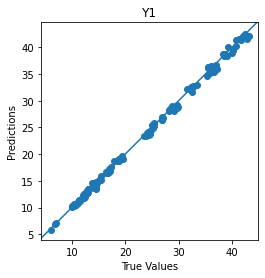

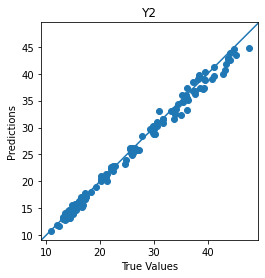

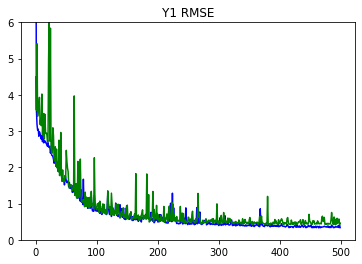

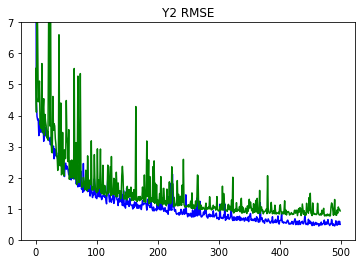

In [13]:
# Plot the loss and mse
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)